In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
roi_file_paths = {
                'roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports'
                           },
                'roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/segmentations/nuclei_20240529_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports'
                           },
                'roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports'
                           },
                'timezero_roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/segmentations/segmentation_20240513_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/transcripts/20240517_segmentation_withRefid.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/exports'
                              },
                  'timezero_roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/segmentations/segment_091924_nuclei.tiff',
                            # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                            'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/transcripts/transcripts.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/exports'
                            },
                    'timezero_roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/segmentations/segment_20240921_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/transcripts/transcripts.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/exports'
                              },
                'run2_roi_2':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/',
                            },
                'run2_roi_3':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/',
                            },
                  
                  }

In [6]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# load the sg_object
with open(f'{roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [7]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [10]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [11]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    


In [17]:
# assign all nan_sg_obj to -1
sg_obj.gdf['bc_cluster'] = sg_obj.gdf['bc_cluster'].fillna(-1)

True

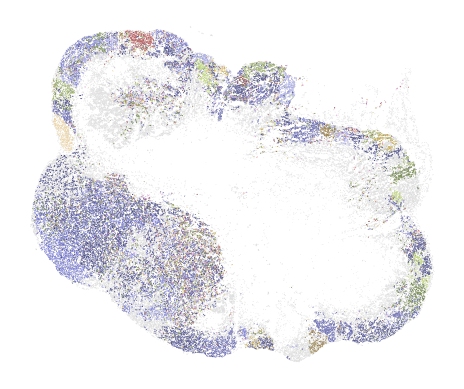

In [51]:
plt.figure()

column_to_use = 'bc_cluster'
# column_to_use = 'barcode_names'

ax = plt.gca()

# colors = 
# cmap = matplotlib.colors.ListedColormap(plt.cm.tab20b.colors + plt.cm.tab20c.colors[:-4], name='tab40')
cmap = plt.cm.tab20b

sg_obj.gdf[pd.isnull(sg_obj.gdf[column_to_use])].plot(color='#d9d9d9',alpha=1.0,ax=ax)
sg_obj.gdf.plot(column=column_to_use,cmap=cmap,ax=ax)


plt.rcParams['figure.facecolor'] = 'w'
# plt.gca().set_facecolor(color='k')
plt.axis('off')
# flip y axis
plt.gca().invert_yaxis()

# plt.
plt.savefig('../graphs/in_vivo_clones_clustered.pdf',bbox_inches='tight',transparent=True)

plt.get_cmap('tab20c')

In [40]:
spots_file = 

TypeError: 'ListedColormap' object is not iterable

In [52]:
spots_df = pd.read_csv(roi_file_paths[roi_of_interest]["spots_file"])

<Figure size 640x480 with 0 Axes>

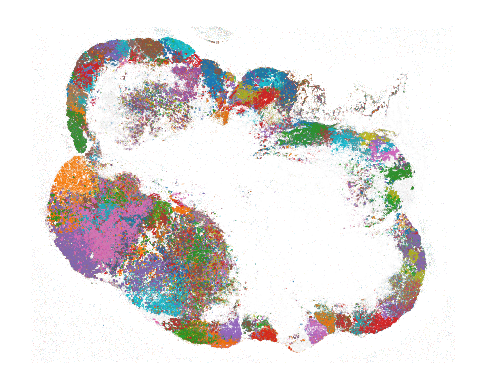

In [56]:
# plt.figure()
gene_of_interest = 'SFRP1'

bc_cols = [col for col in df.columns if 'bc_' in col and 'cluster' not in col]
plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

for gene_of_interest in bc_cols:

    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]

    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0)

plt.axis('off')
# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

# plt.savefig(f'../graphs/space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/in_vivo_barcode_transcripts.png',dpi=1000,bbox_inches='tight',transparent=True)

    

In [54]:
[col for col in df.columns if 'bc_' in col and 'cluster' not in col]

['bc_001',
 'bc_002',
 'bc_003',
 'bc_004',
 'bc_005',
 'bc_006',
 'bc_007',
 'bc_008',
 'bc_009',
 'bc_010',
 'bc_011',
 'bc_012',
 'bc_013',
 'bc_014',
 'bc_015',
 'bc_016',
 'bc_017',
 'bc_018',
 'bc_019',
 'bc_020',
 'bc_021',
 'bc_022',
 'bc_023',
 'bc_024',
 'bc_025',
 'bc_026',
 'bc_027',
 'bc_028',
 'bc_029',
 'bc_030',
 'bc_031',
 'bc_032',
 'bc_033',
 'bc_034',
 'bc_035',
 'bc_036',
 'bc_037',
 'bc_038',
 'bc_039',
 'bc_040',
 'bc_041',
 'bc_042',
 'bc_043',
 'bc_044',
 'bc_045',
 'bc_046',
 'bc_047',
 'bc_048',
 'bc_049',
 'bc_050',
 'bc_051',
 'bc_052',
 'bc_053',
 'bc_054',
 'bc_055',
 'bc_056',
 'bc_057',
 'bc_058',
 'bc_059',
 'bc_060',
 'bc_061',
 'bc_062',
 'bc_063',
 'bc_064',
 'bc_065',
 'bc_066',
 'bc_067',
 'bc_068',
 'bc_069',
 'bc_070',
 'bc_071',
 'bc_072',
 'bc_073',
 'bc_074',
 'bc_075',
 'bc_076',
 'bc_077',
 'bc_078',
 'bc_079',
 'bc_080',
 'bc_081',
 'bc_082',
 'bc_083',
 'bc_084',
 'bc_085',
 'bc_086',
 'bc_087',
 'bc_088',
 'bc_089',
 'bc_090',
 'bc_091',